In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#imports for handling transaction
import joblib 
from solcx import install_solc, compile_source
#Specific Solidity version harhat works well with / there is more documentation for
install_solc('0.8.0')
from solcx import set_solc_version
set_solc_version('0.8.0')
from solcx import compile_source
from web3 import Web3

In [3]:

# Load the dataset
try:
    data = pd.read_csv('transactions.csv')
except FileNotFoundError:
    print("Error: The file 'transactions.csv' was not found.")
    exit()


In [4]:

# Preview data
print("Data Preview:")
print(data.head())


Data Preview:
   accountNumber accountOpenDate acqCountry  availableMoney  cardCVV  \
0      737265056      2015-03-14         US          5000.0      414   
1      737265056      2015-03-14         US          5000.0      486   
2      737265056      2015-03-14         US          5000.0      486   
3      737265056      2015-03-14         US          5000.0      486   
4      830329091      2015-08-06         US          5000.0      885   

   cardLast4Digits  cardPresent  creditLimit  currentBalance currentExpDate  \
0             1803        False       5000.0             0.0        06/2023   
1              767         True       5000.0             0.0        02/2024   
2              767        False       5000.0             0.0        08/2025   
3              767        False       5000.0             0.0        08/2025   
4             3143         True       5000.0             0.0        10/2029   

   ...         merchantName merchantState  merchantZip  posConditionCode  \
0 

In [5]:

# Function to dynamically set features
# choose from any column in the dataset
selected_features = ['creditLimit', 'availableMoney', 'transactionAmount', 'expirationDateKeyInMatch', 'cardPresent']
def update_features(new_features):
    global selected_features
    selected_features = new_features


In [6]:

# Define the target variable
target = 'isFraud'


In [7]:
# Ensure non-negative values in X and handle NaN values
# some later function used do not work with negative values and NaN values
X = data[selected_features].apply(lambda x: np.maximum(x, 0)).fillna(0)
# Converts the target column values into binary integers (1 or 0).
y = data[target].apply(lambda x: 1 if str(x).strip().upper() == 'TRUE' else 0).fillna(0)


In [8]:
# Feature Selection

# Select the top 5 features based on the chi-squared statistical test
selector = SelectKBest(chi2, k=5)
# Fit the selector to the data and transform the features
X_new = selector.fit_transform(X, y)
# Get the names of the selected features
selected_features = X.columns[selector.get_support(indices=True)]
# Print the selected features
print("\nSelected Features after SelectKBest:")
print(selected_features)



Selected Features after SelectKBest:
Index(['creditLimit', 'availableMoney', 'transactionAmount',
       'expirationDateKeyInMatch', 'cardPresent'],
      dtype='object')


In [9]:

# Split data into training and testing sets
def split_data(test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets.

    Parameters:
        test_size (float): The proportion of the dataset to include in the test split. Default is 0.2 (20%).
        random_state (int): Controls the shuffling applied to the data before splitting. Ensures reproducibility when set.

    Returns:
        tuple: Training and testing sets for features (X) and target (y).
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


In [10]:

# Handle Continuous Variables
# Discretize continuous features into ordinal bins
# When training, some columns were split into multiple columns so this helped brought them back together
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

In [11]:
# Balance the Target Variable
# Apply SMOTE to balance the dataset by generating synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_new, y)

In [15]:
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(X_resampled, y_resampled):
    """
    Performs hyperparameter tuning using GridSearchCV on the resampled training data.
    
    Parameters:
        X_resampled: The resampled feature data.
        y_resampled: The resampled target data.
    
    Returns:
        The best DecisionTreeClassifier model with optimal parameters.
    """
    # Define the parameter grid to search over
    param_grid = {
        'max_depth': [3, 5, 10],  # Maximum depth of the tree
        'min_samples_split': [10, 20, 50],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [5, 10, 20]  # Minimum number of samples required to be at a leaf node
    }
    
    # Set up the GridSearchCV object
    grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),  # The model to be optimized, use a consistent random state  for 
        param_grid=param_grid,  # The parameter grid to search over
        cv=5,  # Number of cross-validation folds
        scoring='f1',  # Optimize for F1 score to balance precision and recall
        n_jobs=-1,  # Use all available CPU cores
        verbose=2  # Verbosity level for logging
    )
    
    # Fit the GridSearchCV object to the resampled data
    grid_search.fit(X_resampled, y_resampled)
    
    # Print the best parameters and the best cross-validated F1 score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validated F1 Score:", grid_search.best_score_)
    
    # Return the best estimator (model) found by GridSearchCV
    return grid_search.best_estimator_
    #print("Best Parameters:", grid_search.best_params_)

# Update the train_and_evaluate function to use the tuned model
def train_and_evaluate_with_tuning(test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = split_data(test_size, random_state)
    
    # Apply KBinsDiscretizer to transactionAmount
    X_train.iloc[:, 2] = kbins.fit_transform(X_train.iloc[:, 2].values.reshape(-1, 1)).flatten()
    X_test.iloc[:, 2] = kbins.transform(X_test.iloc[:, 2].values.reshape(-1, 1)).flatten()

    # Balance the Target Variable
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Tune hyperparameters on the resampled training data
    dt_classifier = tune_hyperparameters(X_resampled, y_resampled)
    # dt_classifier = DecisionTreeClassifier(class_weight={0: 1, 1: 3}, random_state=42)


    # Evaluate the tuned model on the test set
    y_pred = dt_classifier.predict(X_test)
    print("\nModel Evaluation After Tuning:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Visualize confusion matrix with seaborn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(dt_classifier, feature_names=X_train.columns, class_names=['Not Fraud', 'Fraud'], filled=True)
    plt.show()

    # Visualize the decision tree
    # plt.figure(figsize=(20, 10))
    # plot_tree(dt_classifier, feature_names=selected_features, class_names=['Not Fraud', 'Fraud'], filled=True)
    # plt.show()

    return dt_classifier#, X_resampled, y_resampled


In [16]:

# Function to explain the decision tree
def explain_decision_tree(model):
    print("\nFeature Importances:")
    for feature, importance in zip(selected_features, model.feature_importances_):
        print(f"{feature}: {importance:.4f}")

    print("\nExample Decision Path Explanation:")
    from sklearn.tree import export_text
    tree_rules = export_text(model, feature_names=selected_features)
    print(tree_rules)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best Cross-Validated F1 Score: 0.7463051600584238

Model Evaluation After Tuning:
Accuracy: 0.4527032612082176

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.45      0.62    154780
           1       0.02      0.71      0.04      2493

    accuracy                           0.45    157273
   macro avg       0.51      0.58      0.33    157273
weighted avg       0.97      0.45      0.61    157273


Confusion Matrix:
[[69425 85355]
 [  720  1773]]


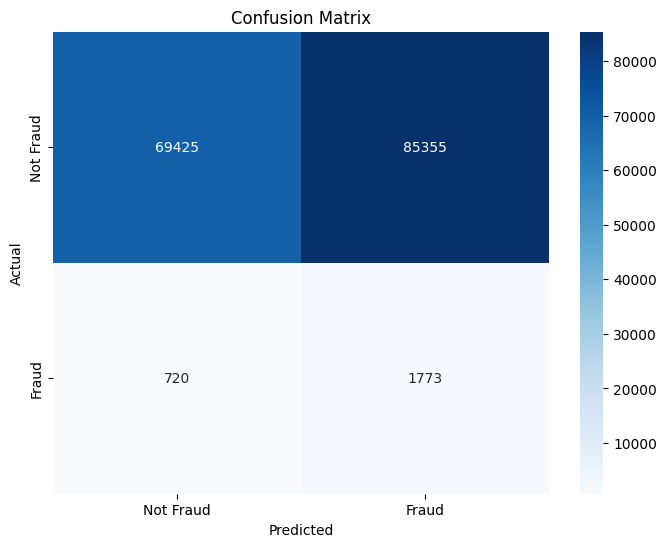

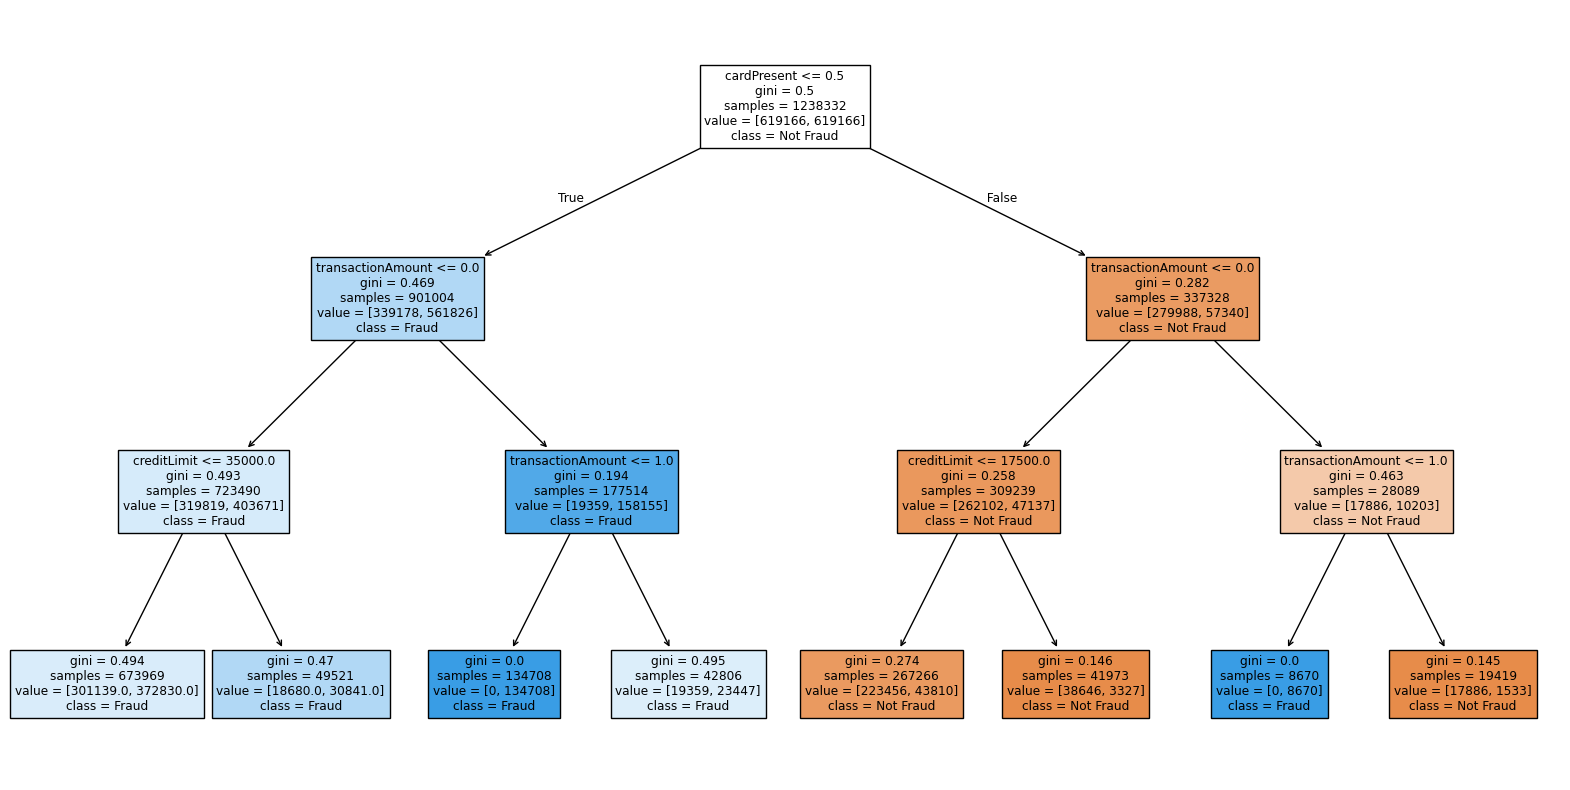

In [17]:

# Example Usage
update_features(['creditLimit', 'availableMoney', 'transactionAmount', 'expirationDateKeyInMatch', 'cardPresent'])
# train_and_evaluate(test_size=0.3, random_state=42)
dt_classifier = train_and_evaluate_with_tuning(test_size=0.2, random_state=42)



In [24]:
import joblib  # Import joblib to save and load models

# Save the trained Decision Tree model
model_filename = 'fraud_detection_model.pkl'  # Define the filename
joblib.dump(dt_classifier, model_filename)  # Save the model to a .pkl file
print(f"\nModel saved as {model_filename}")



Model saved as fraud_detection_model.pkl


(TP = True Positive, FP = False Positive)

precision = TP/(TP+FP)


recall = TP/(TP+FN)

In [25]:
from sklearn.model_selection import GridSearchCV
'''
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
'''

'\nparam_grid = {\n    \'max_depth\': [3, 5, 10],\n    \'min_samples_split\': [10, 20, 50],\n    \'min_samples_leaf\': [5, 10, 20]\n}\ngrid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring=\'f1\')\ngrid_search.fit(X_resampled, y_resampled)\nbest_params = grid_search.best_params_\nprint("Best Parameters:", best_params)\n'

In [26]:
# Save the trained Decision Tree model
model_filename = 'fraud_detection_model.pkl'  # Define the filename
joblib.dump(dt_classifier, model_filename)  # Save the model to a .pkl file
print(f"\nModel saved as {model_filename}")



Model saved as fraud_detection_model.pkl


In [ ]:
#!pip install web3 py-solc-x


In [21]:
# Compile contract
contract_source = '''
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract Escrow {
    address public payer;
    address public payee;
    uint public amount;
    bool public isFraudulent;

    constructor(address _payee) payable {
        payer = msg.sender;
        payee = _payee;
        amount = msg.value;
        isFraudulent = false;
    }

    function reportFraud() public {
        require(msg.sender == payer, "Only payer can report fraud");
        isFraudulent = true;
    }

    function releaseFunds() public {
        require(!isFraudulent, "Transaction flagged as fraudulent");
        require(msg.sender == payer, "Only payer can release funds");
        payable(payee).transfer(amount);
    }

    function refund() public {
        require(isFraudulent, "Transaction not flagged as fraudulent");
        require(msg.sender == payer, "Only payer can refund");
        payable(payer).transfer(amount);
    }
}

'''


In [22]:

# Compile the contract
compiled_sol = compile_source(contract_source)
#Compiles the Solidity contract (contract_source) into bytecode and an ABI (Application Binary Interface).


# Extract the ABI and bytecode
contract_interface = compiled_sol['<stdin>:Escrow']

# Print the contract interface for debugging
print("Contract Interface:", contract_interface)
#ontract_interface: Extracts the compiled contract's ABI and bytecode, which are required for deploying and interacting with the smart contract.

Contract Interface: {'abi': [{'inputs': [{'internalType': 'address', 'name': '_payee', 'type': 'address'}], 'stateMutability': 'payable', 'type': 'constructor'}, {'inputs': [], 'name': 'amount', 'outputs': [{'internalType': 'uint256', 'name': '', 'type': 'uint256'}], 'stateMutability': 'view', 'type': 'function'}, {'inputs': [], 'name': 'isFraudulent', 'outputs': [{'internalType': 'bool', 'name': '', 'type': 'bool'}], 'stateMutability': 'view', 'type': 'function'}, {'inputs': [], 'name': 'payee', 'outputs': [{'internalType': 'address', 'name': '', 'type': 'address'}], 'stateMutability': 'view', 'type': 'function'}, {'inputs': [], 'name': 'payer', 'outputs': [{'internalType': 'address', 'name': '', 'type': 'address'}], 'stateMutability': 'view', 'type': 'function'}, {'inputs': [], 'name': 'refund', 'outputs': [], 'stateMutability': 'nonpayable', 'type': 'function'}, {'inputs': [], 'name': 'releaseFunds', 'outputs': [], 'stateMutability': 'nonpayable', 'type': 'function'}, {'inputs': [],

In [ ]:
# Connect to the Hardhat network

#Open a new terminal and run
#npm install --save-dev hardhat
# hardhat init
#create an empty Hardhat project 
#run 'npx hardhat node'

#to start a local Ethereum blockchain.
w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545'))
#Connects to the local Ethereum blockchain (running on Hardhat at 127.0.0.1:8545).

# Verify the connection
if w3.is_connected():
    print("Connected to Hardhat network")
else:
    print("Failed to connect")

Connected to Hardhat network


The data used to train the decision tree is different from the characteristics of the eth accounts so I had to make fake metadata to validate the transactions

In [29]:
w3.eth.default_account = w3.eth.accounts[0]

# Load AI model
model = joblib.load('fraud_detection_model.pkl')

# Example transaction metadata
tx_metadata = {
    'creditLimit': 500,          # Example data
    'availableMoney': 300,       
    'transactionAmount': 100,    
    'posConditionCode': 1,       
    'cardPresent': 1             
}

# Preprocess transaction data for decision tree
transaction_features = [
    tx_metadata['creditLimit'],        
    tx_metadata['availableMoney'],
    tx_metadata['transactionAmount'],  
    tx_metadata['posConditionCode'],  
    tx_metadata['cardPresent']         
]

tx_metadata.get('availableMoney', 0)


# Predict fraud
is_fraud = model.predict([transaction_features])[0]


C:\Users\josma\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [30]:
# Define payer and payee
payer_address = w3.eth.accounts[0]
#account that will send the funds and deploy the contract.
payee_address = w3.eth.accounts[1]
#account that will receive the funds if the transaction is not flagged as fraudulent.
w3.eth.default_account = payer_address
#Sets the default account (payer_address) for transactions.

In [31]:
# Deploy the contract
Escrow = w3.eth.contract(abi=contract_interface['abi'], bytecode=contract_interface['bin'])
# w3.eth.contract(): Creates a Python object representing the smart contract.
# abi: Specifies how to interact with the contract (function names, parameters, etc.).
# bytecode: The compiled binary code of the contract.

tx_hash = Escrow.constructor(payee_address).transact({'value': Web3.to_wei(1, 'ether')})
# constructor(payee_address): Calls the contract’s constructor, passing payee_address as an argument.
# transact({'value': Web3.to_wei(1, 'ether')}):
# Sends 1 Ether from the default_account to deploy the contract.
# The value field specifies the amount of Ether sent with the transaction.
tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash)

# Ensure deployment was successful
if not tx_receipt:
    print("Deployment failed. No transaction receipt received.")
else:
    contract_address = tx_receipt.contractAddress
    # Ethereum address of the newly deployed contract.
    print(f"Contract deployed at {contract_address}")

# Interact with the contract
Escrow = w3.eth.contract(address=contract_address, abi=contract_interface['abi'])

# Example: Fraud detection integration
if is_fraud:
    tx_hash = Escrow.functions.reportFraud().transact({'from': w3.eth.default_account})
    print("Fraud reported. Funds not released.")
else:
    tx_hash = Escrow.functions.releaseFunds().transact({'from': w3.eth.default_account})
    print("Funds released to payee.")


Contract deployed at 0x5FbDB2315678afecb367f032d93F642f64180aa3
Funds released to payee.
